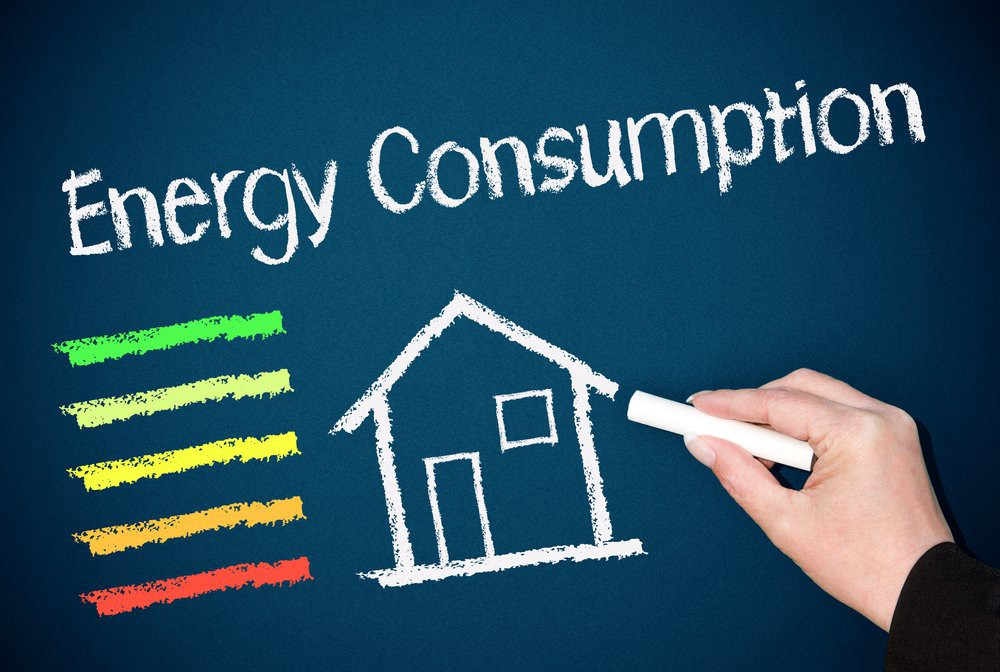

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

reference: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

In [6]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df.head(3)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0


In [7]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [8]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [9]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


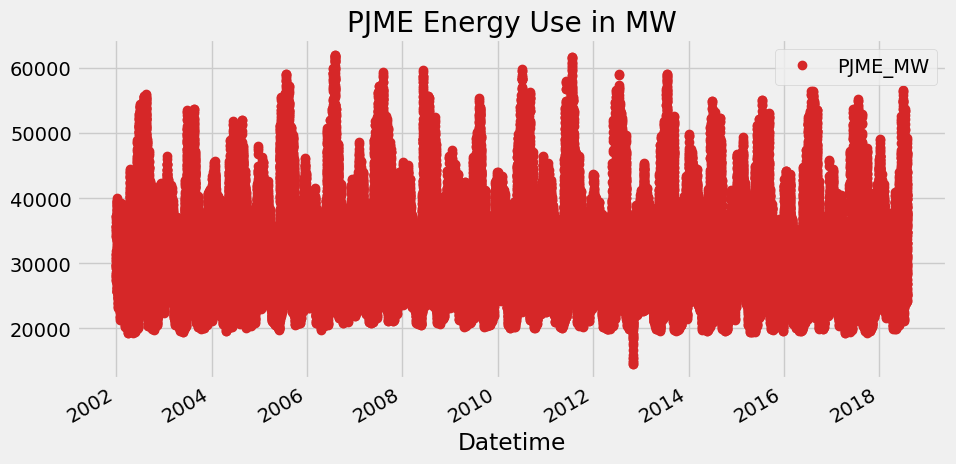

In [17]:
df.plot(style='o',
        figsize=(10, 5),
        color=color_pal[3],
        title='PJME Energy Use in MW')
plt.show()

# Outlier handlingOutlier Analysis and removal

<AxesSubplot:ylabel='Frequency'>

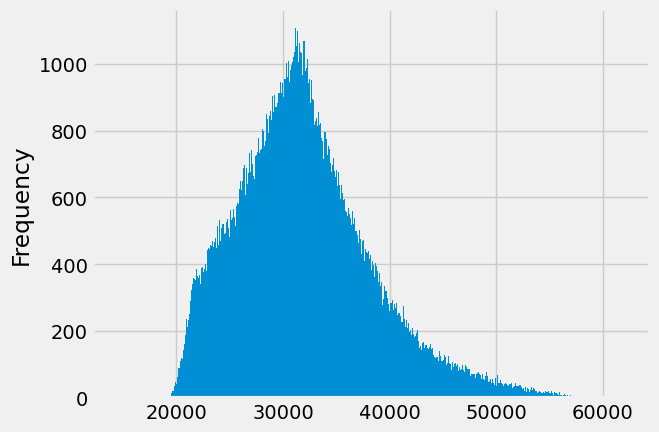

In [18]:
df['PJME_MW'].plot(kind='hist', bins=500)

<AxesSubplot:title={'center':'Outliers'}, xlabel='Datetime'>

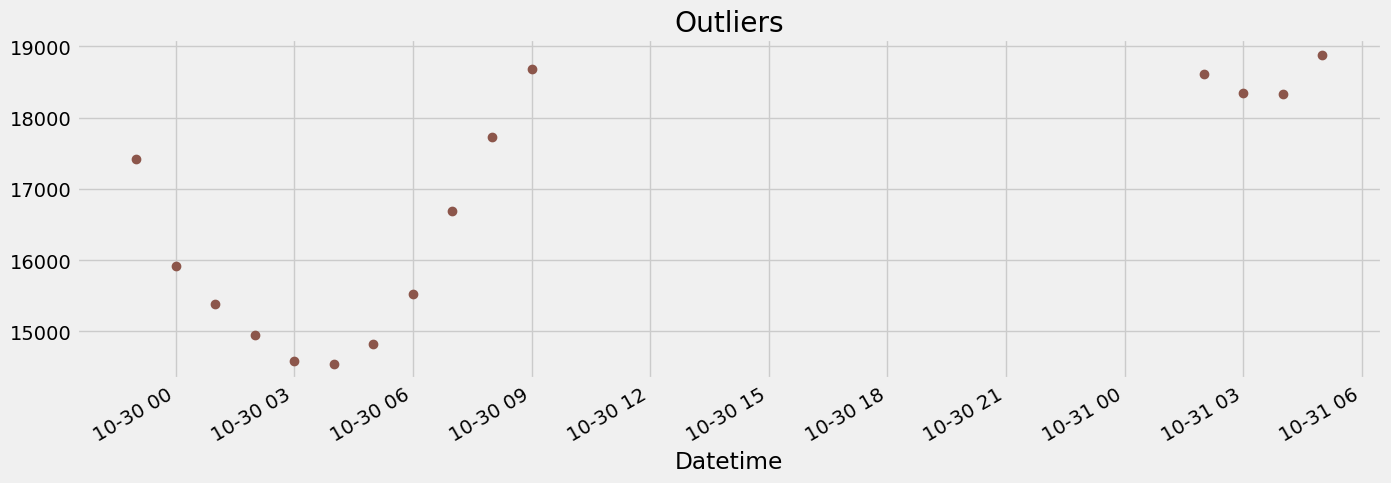

In [20]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='o',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [21]:
df = df.query('PJME_MW > 19_000').copy()

# Train / Test Split

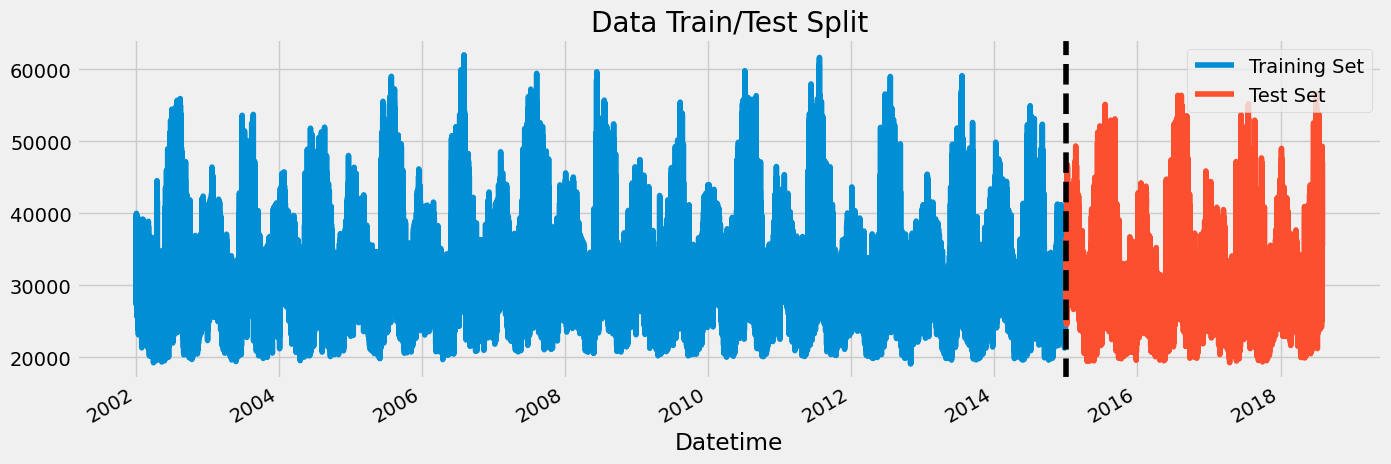

In [22]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

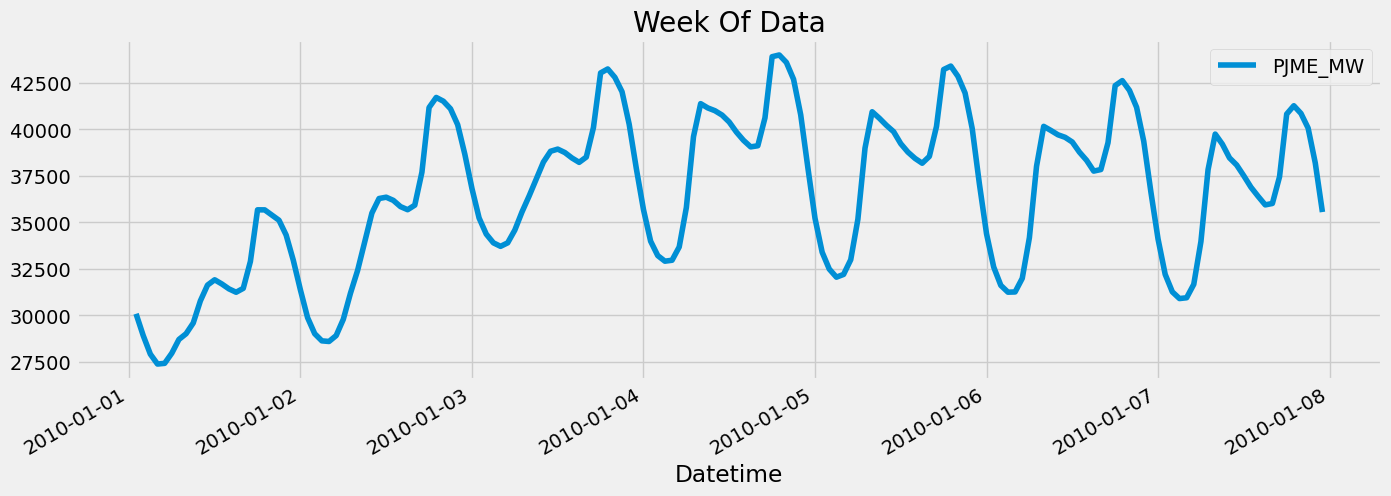

In [23]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# TimeSeries Cross Validation

In [24]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

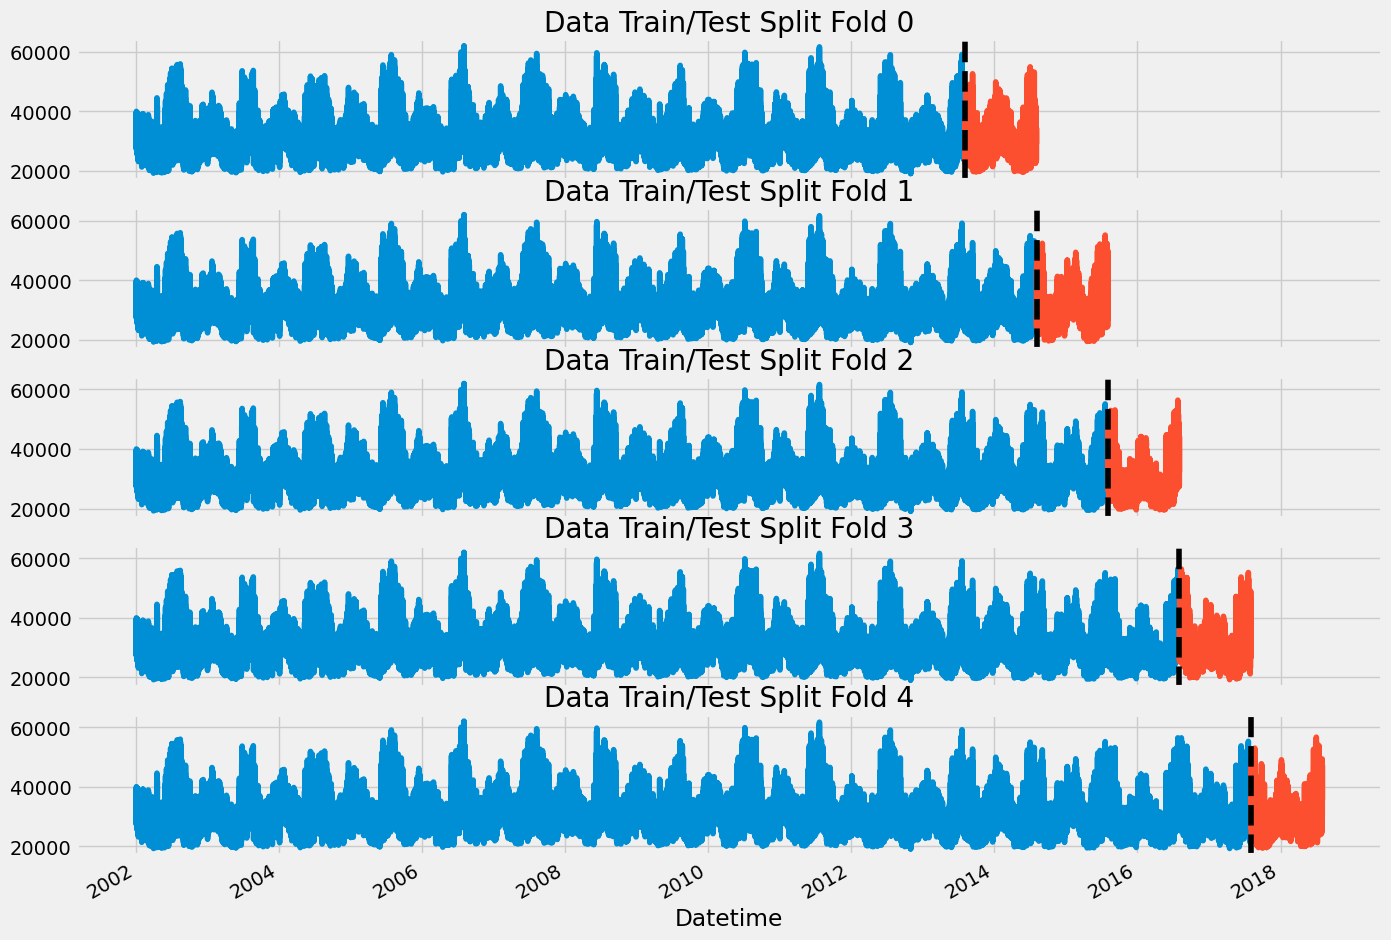

In [26]:
fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# Feature Creation

In [27]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [29]:
df.sample(5)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2005-02-24 11:00:00,38291.0,11,3,1,2,2005,55,24,8
2005-07-30 18:00:00,43020.0,18,5,3,7,2005,211,30,30
2012-10-14 15:00:00,25395.0,15,6,4,10,2012,288,14,41
2008-05-07 01:00:00,24196.0,1,2,2,5,2008,128,7,19
2002-05-12 14:00:00,26418.0,14,6,2,5,2002,132,12,19


# Lag Features

In [30]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [31]:
df = add_lags(df)

In [32]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0


# Visualize our Feature / Target Relationship

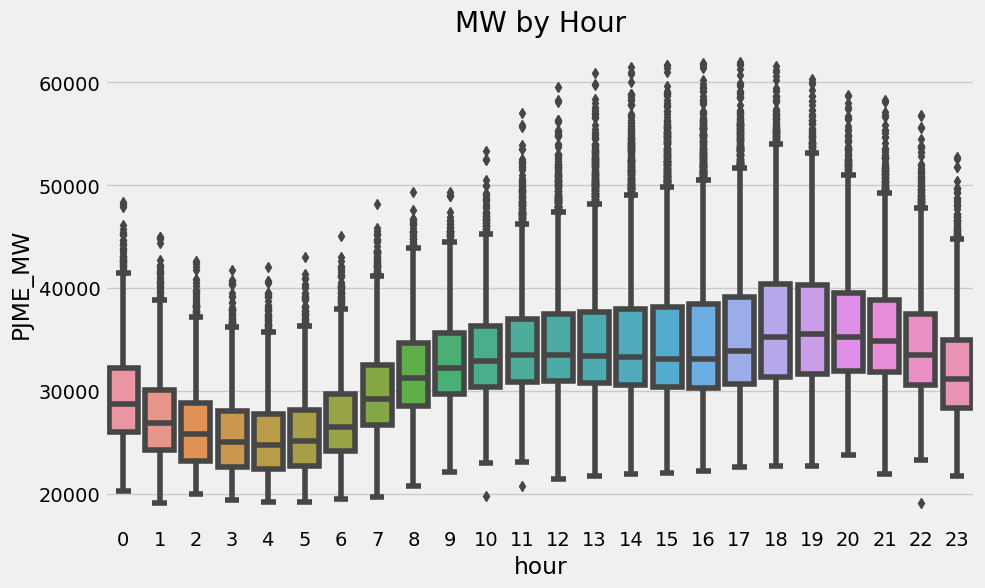

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

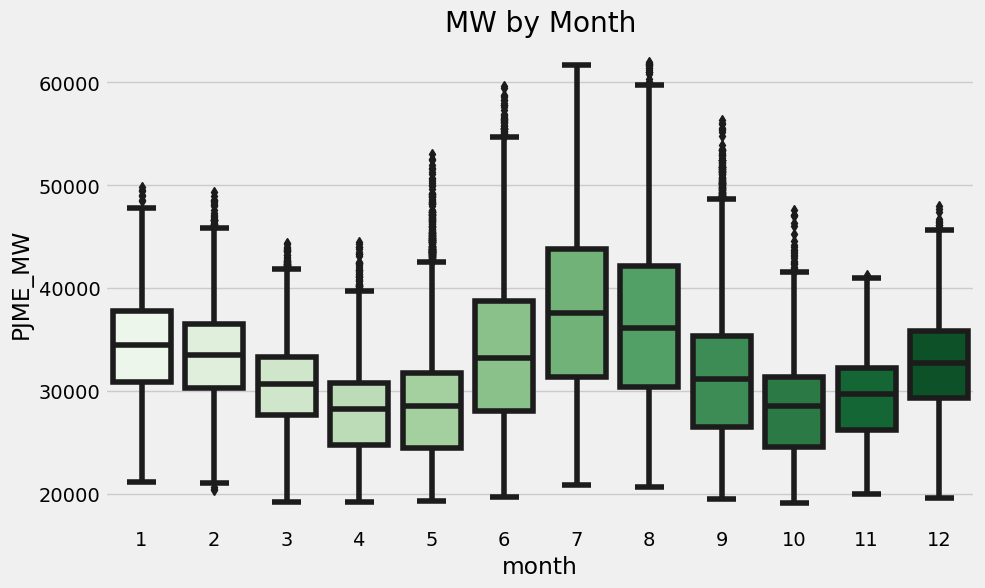

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Greens')
ax.set_title('MW by Month')
plt.show()

# Create our Model

In [39]:
fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year','lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(n_estimators=1000,
                           early_stopping_rounds=50,
                           max_depth=3,
                           learning_rate=0.01)
#Early stopping is a technique used to stop training when the loss on validation dataset starts increase (in the case of minimizing the loss)

    reg.fit(X_train, 
            y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    

[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.15798	validation_1-rmse:11907.12157
[200]	validation_0-rmse:5744.94936	validation_1-rmse:5353.51632
[300]	validation_0-rmse:3868.56640	validation_1-rmse:3898.53908
[400]	validation_0-rmse:3430.63336	validation_1-rmse:3758.24522
[451]	validation_0-rmse:3355.51655	validation_1-rmse:3763.34980
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.57784	validation_1-rmse:12221.41614
[200]	validation_0-rmse:5755.56552	validation_1-rmse:5655.33259
[300]	validation_0-rmse:3904.98895	validation_1-rmse:3931.65967
[400]	validation_0-rmse:3476.76871	validation_1-rmse:3598.75393
[500]	validation_0-rmse:3355.49568	validation_1-rmse:3530.19662
[600]	validation_0-rmse:3298.89678	validation_1-rmse:3492.70060
[700]	validation_0-rmse:3258.68974	validation_1-rmse:3468.00301
[800]	validation_0-rmse:3224.41851	validation_1-rmse:3446.84051
[900]	validation_0-rmse:3196.68131	v

In [40]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3753.5994
Fold scores:[3757.485267269142, 3422.628654218696, 3473.0621874794947, 4115.966281700851, 3998.8545666889618]


# Predict the Future

In [41]:
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year','lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[12:22:38] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.43427
[200]	validation_0-rmse:5752.11136
[300]	validation_0-rmse:3971.36505
[400]	validation_0-rmse:3571.35729
[499]	validation_0-rmse:3456.28762


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [42]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [43]:
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [44]:
future_w_features = df_and_future.query('isFuture').copy()

In [45]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

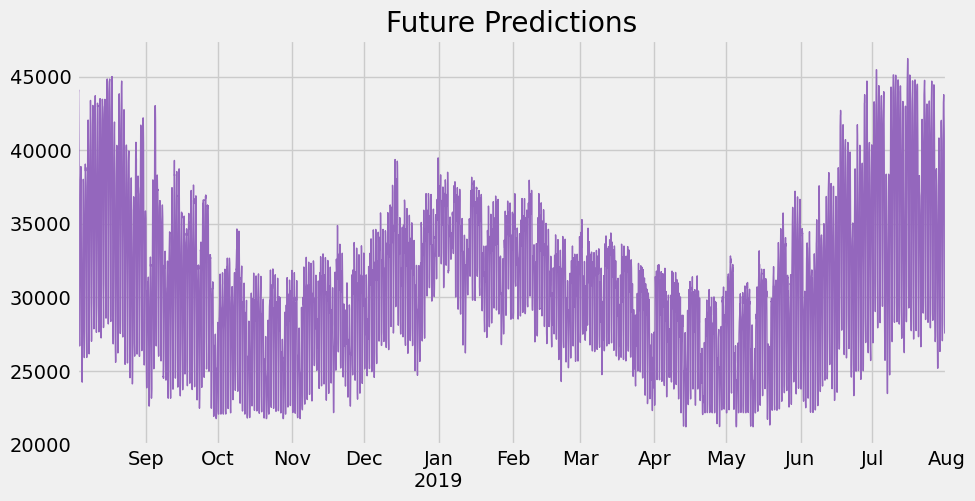

In [46]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

# Feature Importance

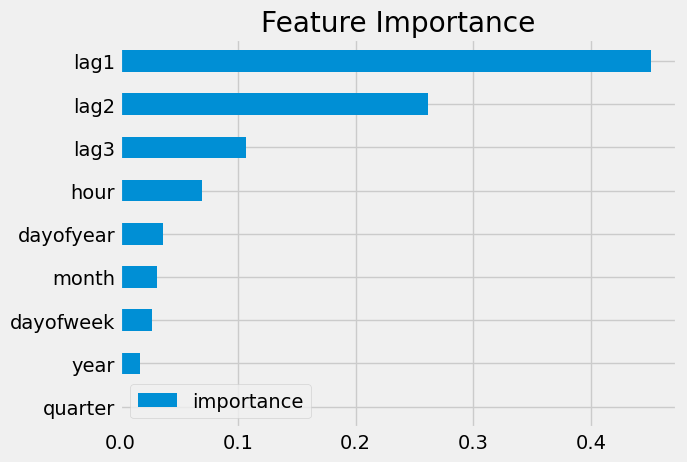

In [47]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [48]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

KeyError: 'prediction'